In [107]:
import random
import numpy as np
from PIL import Image
from copy import deepcopy

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, Resize
from torch.utils.data import random_split, WeightedRandomSampler


from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, MultiStepLR, CyclicLR, LambdaLR

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

# for download rps
import requests
import zipfile
import os
import errno

## Architecture class

In [113]:
class Architecture(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

        # for hook purposes
        self.handles = {}
        self.visualization = {}

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    # this function was updated in this class
    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)
        random.seed(seed)
        try:
            self.train_loader.sampler.generator.manual_seed(seed)
        except AttributeError:
            pass

    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def count_parameters(self):
      return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    @staticmethod
    def _visualize_tensors(axs, x, y=None, yhat=None, layer_name='', title=None):
        # The number of images is the number of subplots in a row
        n_images = len(axs)
        # Gets max and min values for scaling the grayscale
        minv, maxv = np.min(x[:n_images]), np.max(x[:n_images])
        # For each image
        for j, image in enumerate(x[:n_images]):
            ax = axs[j]
            # Sets title, labels, and removes ticks
            if title is not None:
                ax.set_title(f'{title} #{j}', fontsize=12)
            shp = np.atleast_2d(image).shape
            ax.set_ylabel(
                f'{layer_name}\n{shp[0]}x{shp[1]}',
                rotation=0, labelpad=40
            )
            xlabel1 = '' if y is None else f'\nLabel: {y[j]}'
            xlabel2 = '' if yhat is None else f'\nPredicted: {yhat[j]}'
            xlabel = f'{xlabel1}{xlabel2}'
            if len(xlabel):
                ax.set_xlabel(xlabel, fontsize=12)
            ax.set_xticks([])
            ax.set_yticks([])

            # Plots weight as an image
            ax.imshow(
                np.atleast_2d(image.squeeze()),
                cmap='gray',
                vmin=minv,
                vmax=maxv
            )
        return

    def visualize_filters(self, layer_name, **kwargs):
        try:
            # Gets the layer object from the model
            layer = self.model
            for name in layer_name.split('.'):
                layer = getattr(layer, name)
            # We are only looking at filters for 2D convolutions
            if isinstance(layer, nn.Conv2d):
                # Takes the weight information
                weights = layer.weight.data.cpu().numpy()
                # weights -> (channels_out (filter), channels_in, H, W)
                n_filters, n_channels, _, _ = weights.shape

                # Builds a figure
                size = (2 * n_channels + 2, 2 * n_filters)
                fig, axes = plt.subplots(n_filters, n_channels,
                                        figsize=size)
                axes = np.atleast_2d(axes)
                axes = axes.reshape(n_filters, n_channels)
                # For each channel_out (filter)
                for i in range(n_filters):
                    Architecture._visualize_tensors(
                        axes[i, :],
                        weights[i],
                        layer_name=f'Filter #{i}',
                        title='Channel'
                    )

                for ax in axes.flat:
                    ax.label_outer()

                fig.tight_layout()
                return fig
        except AttributeError:
            return

    def attach_hooks(self, layers_to_hook, hook_fn=None):
        # Clear any previous values
        self.visualization = {}
        # Creates the dictionary to map layer objects to their names
        modules = list(self.model.named_modules())
        layer_names = {layer: name for name, layer in modules[1:]}

        if hook_fn is None:
            # Hook function to be attached to the forward pass
            def hook_fn(layer, inputs, outputs):
                # Gets the layer name
                name = layer_names[layer]
                # Detaches outputs
                values = outputs.detach().cpu().numpy()
                # Since the hook function may be called multiple times
                # for example, if we make predictions for multiple mini-batches
                # it concatenates the results
                if self.visualization[name] is None:
                    self.visualization[name] = values
                else:
                    self.visualization[name] = np.concatenate([self.visualization[name], values])

        for name, layer in modules:
            # If the layer is in our list
            if name in layers_to_hook:
                # Initializes the corresponding key in the dictionary
                self.visualization[name] = None
                # Register the forward hook and keep the handle in another dict
                self.handles[name] = layer.register_forward_hook(hook_fn)

    def remove_hooks(self):
        # Loops through all hooks and removes them
        for handle in self.handles.values():
            handle.remove()
        # Clear the dict, as all hooks have been removed
        self.handles = {}

    def visualize_outputs(self, layers, n_images=10, y=None, yhat=None):
        layers = filter(lambda l: l in self.visualization.keys(), layers)
        layers = list(layers)
        shapes = [self.visualization[layer].shape for layer in layers]
        n_rows = [shape[1] if len(shape) == 4 else 1
                  for shape in shapes]
        total_rows = np.sum(n_rows)

        fig, axes = plt.subplots(total_rows, n_images,
                                figsize=(1.5*n_images, 1.5*total_rows))
        axes = np.atleast_2d(axes).reshape(total_rows, n_images)

        # Loops through the layers, one layer per row of subplots
        row = 0
        for i, layer in enumerate(layers):
            start_row = row
            # Takes the produced feature maps for that layer
            output = self.visualization[layer]

            is_vector = len(output.shape) == 2

            for j in range(n_rows[i]):
                Architecture._visualize_tensors(
                    axes[row, :],
                    output if is_vector else output[:, j].squeeze(),
                    y,
                    yhat,
                    layer_name=layers[i] \
                              if is_vector \
                              else f'{layers[i]}\nfil#{row-start_row}',
                    title='Image' if (row == 0) else None
                )
                row += 1

        for ax in axes.flat:
            ax.label_outer()

        plt.tight_layout()
        return fig

    def correct(self, x, y, threshold=.5):
        self.model.eval()
        yhat = self.model(x.to(self.device))
        y = y.to(self.device)
        self.model.train()

        # We get the size of the batch and the number of classes
        # (only 1, if it is binary)
        n_samples, n_dims = yhat.shape
        if n_dims > 1:
            # In a multiclass classification, the biggest logit
            # always wins, so we don't bother getting probabilities

            # This is PyTorch's version of argmax,
            # but it returns a tuple: (max value, index of max value)
            _, predicted = torch.max(yhat, 1)
        else:
            n_dims += 1
            # In binary classification, we NEED to check if the
            # last layer is a sigmoid (and then it produces probs)
            if isinstance(self.model, nn.Sequential) and \
              isinstance(self.model[-1], nn.Sigmoid):
                predicted = (yhat > threshold).long()
            # or something else (logits), which we need to convert
            # using a sigmoid
            else:
                predicted = (F.sigmoid(yhat) > threshold).long()

        # How many samples got classified correctly for each class
        result = []
        for c in range(n_dims):
            n_class = (y == c).sum().item()
            n_correct = (predicted[y == c] == c).sum().item()
            result.append((n_correct, n_class))
        return torch.tensor(result)


    @staticmethod
    def loader_apply(loader, func, reduce='sum'):
        results = [func(x, y) for i, (x, y) in enumerate(loader)]
        results = torch.stack(results, axis=0)

        if reduce == 'sum':
            results = results.sum(axis=0)
        elif reduce == 'mean':
            results = results.float().mean(axis=0)

        return results

    @staticmethod
    def statistics_per_channel(images, labels):
        # NCHW
        n_samples, n_channels, n_height, n_weight = images.size()
        # Flatten HW into a single dimension
        flatten_per_channel = images.reshape(n_samples, n_channels, -1)

        # Computes statistics of each image per channel
        # Average pixel value per channel
        # (n_samples, n_channels)
        means = flatten_per_channel.mean(axis=2)
        # Standard deviation of pixel values per channel
        # (n_samples, n_channels)
        stds = flatten_per_channel.std(axis=2)

        # Adds up statistics of all images in a mini-batch
        # (1, n_channels)
        sum_means = means.sum(axis=0)
        sum_stds = stds.sum(axis=0)
        # Makes a tensor of shape (1, n_channels)
        # with the number of samples in the mini-batch
        n_samples = torch.tensor([n_samples]*n_channels).float()

        # Stack the three tensors on top of one another
        # (3, n_channels)
        return torch.stack([n_samples, sum_means, sum_stds], axis=0)

    @staticmethod
    def make_normalizer(loader):
        total_samples, total_means, total_stds = Architecture.loader_apply(loader, Architecture.statistics_per_channel)
        norm_mean = total_means / total_samples
        norm_std = total_stds / total_samples
        return Normalize(mean=norm_mean, std=norm_std)

    def lr_range_test(self, data_loader, end_lr, num_iter=100, step_mode='exp', alpha=0.05, ax=None):
        # Since the test updates both model and optimizer we need to store
        # their initial states to restore them in the end
        previous_states = {'model': deepcopy(self.model.state_dict()),
                          'optimizer': deepcopy(self.optimizer.state_dict())}
        # Retrieves the learning rate set in the optimizer
        start_lr = self.optimizer.state_dict()['param_groups'][0]['lr']

        # Builds a custom function and corresponding scheduler
        lr_fn = make_lr_fn(start_lr, end_lr, num_iter)
        scheduler = LambdaLR(self.optimizer, lr_lambda=lr_fn)

        # Variables for tracking results and iterations
        tracking = {'loss': [], 'lr': []}
        iteration = 0

        # If there are more iterations than mini-batches in the data loader,
        # it will have to loop over it more than once
        while (iteration < num_iter):
            # That's the typical mini-batch inner loop
            for x_batch, y_batch in data_loader:
                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)
                # Step 1
                yhat = self.model(x_batch)
                # Step 2
                loss = self.loss_fn(yhat, y_batch)
                # Step 3
                loss.backward()

                # Here we keep track of the losses (smoothed)
                # and the learning rates
                tracking['lr'].append(scheduler.get_last_lr()[0])
                if iteration == 0:
                    tracking['loss'].append(loss.item())
                else:
                    prev_loss = tracking['loss'][-1]
                    smoothed_loss = alpha * loss.item() + (1-alpha) * prev_loss
                    tracking['loss'].append(smoothed_loss)

                iteration += 1
                # Number of iterations reached
                if iteration == num_iter:
                    break

                # Step 4
                self.optimizer.step()
                scheduler.step()
                self.optimizer.zero_grad()

        # Restores the original states
        self.optimizer.load_state_dict(previous_states['optimizer'])
        self.model.load_state_dict(previous_states['model'])

        if ax is None:
            fig, ax = plt.subplots(1, 1, figsize=(6, 4))
        else:
            fig = ax.get_figure()
        ax.plot(tracking['lr'], tracking['loss'])
        if step_mode == 'exp':
            ax.set_xscale('log')
        ax.set_xlabel('Learning Rate')
        ax.set_ylabel('Loss')
        fig.tight_layout()
        return tracking, fig

    def set_optimizer(self, optimizer):
        self.optimizer = optimizer

# Data Generation

>This dataset was created by Laurence Moroney (lmoroney@gmail.com / [laurencemoroney.com](http://www.laurencemoroney.com)) and can be found in his site: [Rock Paper Scissors Dataset](https://laurencemoroney.com/datasets.html#rock-paper-scissors-dataset).

>The dataset is licensed as Creative Commons (CC BY 2.0). No changes were made to the dataset.

In [8]:
def download_rps(localfolder=''):
    filenames = ['rps.zip', 'rps-test-set.zip']
    for filename in filenames:
        try:
            os.mkdir(f'{localfolder}{filename[:-4]}')

            localfile = f'{localfolder}{filename}'
            # url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/{}'
            # Updated from TFDS URL at
            # https://github.com/tensorflow/datasets/blob/master/tensorflow_datasets/datasets/rock_paper_scissors/rock_paper_scissors_dataset_builder.py
            url = 'https://storage.googleapis.com/download.tensorflow.org/data/{}'
            r = requests.get(url.format(filename), allow_redirects=True)
            open(localfile, 'wb').write(r.content)
            with zipfile.ZipFile(localfile, 'r') as zip_ref:
                zip_ref.extractall(localfolder)
        except OSError as e:
            if e.errno != errno.EEXIST:
                raise
            else:
                print(f'{filename[:-4]} folder already exists!')

In [9]:
download_rps()

# Data Preparation

## ImageFolder

In [10]:
# images are resized to 28x28 pixels
# automatically transformed to the RGB color model by the PIL loader,
# thus losing the alpha channel
temp_transform = Compose([Resize(28), ToTensor()])
temp_dataset = ImageFolder(root='rps', transform=temp_transform)

In [11]:
# the second element of this tuple is the label
temp_dataset[0][0].shape, temp_dataset[0][1]

(torch.Size([3, 28, 28]), 0)

In [12]:
# you have 2520 images
temp_dataset[2519][0].shape

torch.Size([3, 28, 28])

## Standardization

In [13]:
temp_loader = DataLoader(temp_dataset, batch_size=16)

In [14]:
# Each column represents a channel
# first row is the number of data points
# second row is the the sum of mean values
# third row is the sum of standard deviations
first_images, first_labels = next(iter(temp_loader))
Architecture.statistics_per_channel(first_images, first_labels)

tensor([[16.0000, 16.0000, 16.0000],
        [13.8748, 13.3048, 13.1962],
        [ 3.0507,  3.8268,  3.9754]])

In [15]:
# We can leverage the loader_apply() method to get the sums for the whole dataset:
results = Architecture.loader_apply(temp_loader, Architecture.statistics_per_channel)
results

tensor([[2520.0000, 2520.0000, 2520.0000],
        [2142.5356, 2070.0806, 2045.1444],
        [ 526.3025,  633.0677,  669.9556]])

In [16]:
2142.5356/2520

0.8502125396825397

In [17]:
526.3025/2520

0.20885019841269842

In [18]:
# we can compute the average mean value and the average standard deviation, per channel.
# Better yet, let’s make it a method that takes a data loader and
# returns an instance of the Normalize() transform
normalizer = Architecture.make_normalizer(temp_loader)
normalizer

Normalize(mean=tensor([0.8502, 0.8215, 0.8116]), std=tensor([0.2089, 0.2512, 0.2659]))

> Remember that PyTorch converts the pixel values into the [0, 1] range. The average mean value of a pixel for the red (first) channel is 0.8502, while its average standard deviation is 0.2089.

>> **IMPORTANT**: Always use the training set to compute statistics
for standardization! This avoid data leakage!!!

## The Real Datasets

In [19]:
composer = Compose([Resize(28),
                    ToTensor(),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

In [20]:
def figure2(first_images, first_labels):
    fig, axs = plt.subplots(1, 6, figsize=(12, 4))
    titles = ['Paper', 'Rock', 'Scissors']
    for i in range(6):
        image, label = ToPILImage()(first_images[i]), first_labels[i]
        axs[i].imshow(image)
        axs[i].set_xticks([])
        axs[i].set_yticks([])
        axs[i].set_title(titles[label], fontsize=12)
    fig.tight_layout()
    return fig

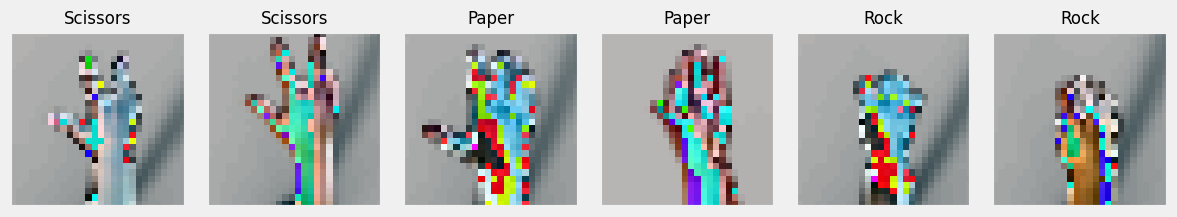

In [21]:
torch.manual_seed(88)
first_images, first_labels = next(iter(train_loader))

fig = figure2(first_images, first_labels)

There is nothing wrong with the colors, it is just the effect of the standardization
of the pixel values.

# Dropout

In [22]:
dropping_model = nn.Sequential(nn.Dropout(p=0.5))

In [23]:
spaced_points = torch.linspace(.1, 1.1, 11)
spaced_points

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

In [24]:
torch.manual_seed(44)

dropping_model.train()
output_train = dropping_model(spaced_points)
output_train

tensor([0.0000, 0.4000, 0.0000, 0.8000, 0.0000, 1.2000, 1.4000, 1.6000, 1.8000,
        0.0000, 2.2000])

![](images/dropout_paper.png)

In [25]:
output_train / spaced_points

tensor([0., 2., 0., 2., 0., 2., 2., 2., 2., 0., 2.])

In [26]:
F.linear(output_train, weight=torch.ones(11), bias=torch.tensor(0))

tensor(9.4000)

In [27]:
dropping_model.eval()
output_eval = dropping_model(spaced_points)
output_eval

tensor([0.1000, 0.2000, 0.3000, 0.4000, 0.5000, 0.6000, 0.7000, 0.8000, 0.9000,
        1.0000, 1.1000])

In [28]:
F.linear(output_eval, weight=torch.ones(11), bias=torch.tensor(0))

tensor(6.6000)

In [29]:
torch.manual_seed(17)
p = 0.5
distrib_outputs = torch.tensor([F.linear(F.dropout(spaced_points, p=p),
                                         weight=torch.ones(11), bias=torch.tensor(0))
                                for _ in range(1000)])

In [30]:
def plot_dist(ax, distrib_outputs, p):
    ax.hist(distrib_outputs, bins=np.linspace(0, 20, 21))
    ax.set_xlabel('Sum of Adjusted Outputs')
    ax.set_ylabel('# of Scenarios')
    ax.set_title('p = {:.2f}'.format(p))
    ax.set_ylim([0, 500])
    mean_value = distrib_outputs.mean()
    ax.plot([mean_value, mean_value], [0, 500], c='r', linestyle='--', label='Mean = {:.2f}'.format(mean_value))
    ax.legend()

In [31]:
def figure7(p, distrib_outputs):
    fig, ax = plt.subplots(1, 1, figsize=(6, 4))
    plot_dist(ax, distrib_outputs, p)
    fig.tight_layout()
    return fig

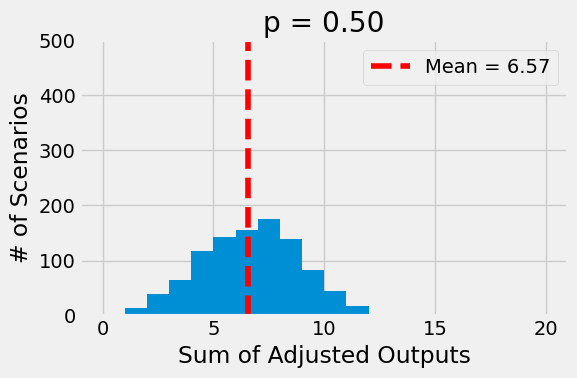

In [32]:
fig = figure7(p, distrib_outputs)

In [33]:
def figure8(ps=(0.1, 0.3, 0.5, 0.9)):
    spaced_points = torch.linspace(.1, 1.1, 11)
    fig, axs = plt.subplots(1, 4, figsize=(15, 4))
    for ax, p in zip(axs.flat, ps):
        torch.manual_seed(17)
        distrib_outputs = torch.tensor([F.linear(F.dropout(spaced_points, p=p),
                                                 weight=torch.ones(11), bias=torch.tensor(0))
                                        for _ in range(1000)])
        plot_dist(ax, distrib_outputs, p)
        ax.label_outer()
    fig.tight_layout()
    return fig

On the left, if there is barely any dropout (p=0.10), the sum of adjusted outputs is
tightly distributed around the mean value. For more typical dropout probabilities
(like 30% or 50%), the distribution may take some more extreme values.


If we go to extremes, like a dropout probability of 90%, the distribution gets a bit
degenerated, I would say—it is pretty much all over the place (and it has a lot of
scenarios where everything gets dropped, hence the tall bar at zero).

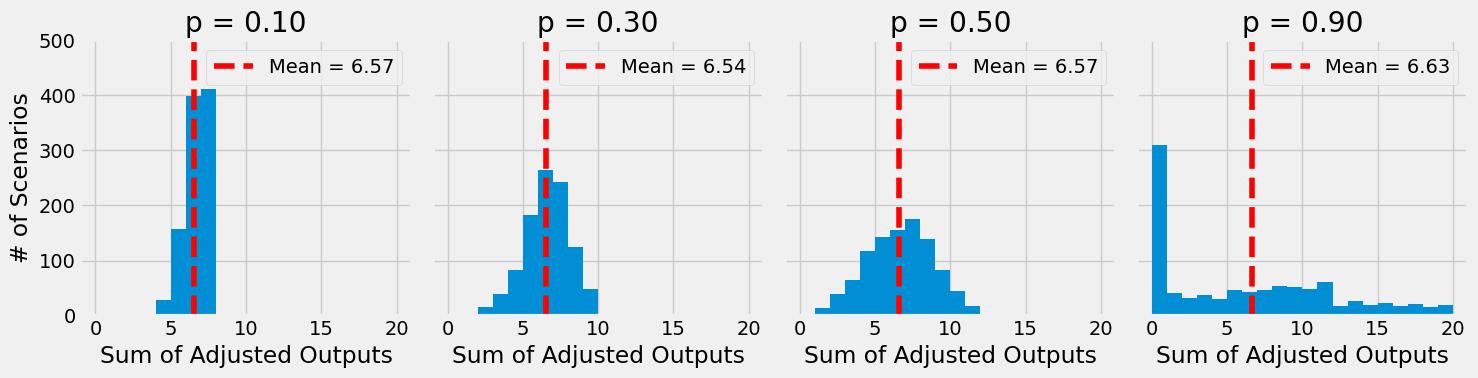

In [34]:
fig = figure8()

The variance of the distribution of outputs grows with the
dropout probability.


A higher dropout probability makes it harder for your model to
learn—that’s what regularization does.

### Two-Dimensional Dropout

In [35]:
def figure9(first_images, seed=17, p=.33):
    torch.manual_seed(seed)
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(ToPILImage()(first_images[0]))
    axs[0].set_title('Original Image')
    axs[0].grid(False)
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].imshow(ToPILImage()(F.dropout(first_images[:1], p=p)[0]))
    axs[1].set_title('Regular Dropout')
    axs[1].grid(False)
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[2].imshow(ToPILImage()(F.dropout2d(first_images[:1], p=p)[0]))
    axs[2].set_title('Two-Dimensional Dropout')
    axs[2].grid(False)
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    fig.tight_layout()
    return fig

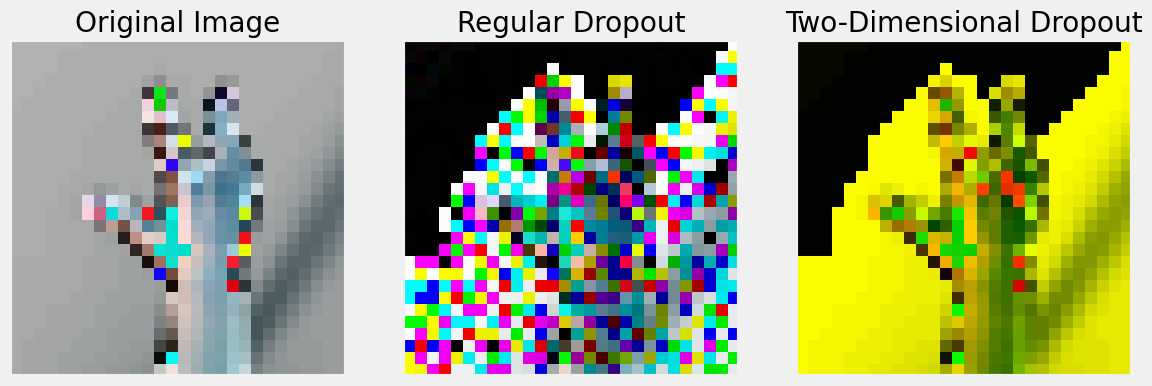

In [36]:
fig = figure9(first_images)

# Fancier Model

Let’s leave the Sequential model aside for now and build a model class again. This
time, our constructor method will take two arguments: ``n_filters`` and ``p``. We’ll use
``n_filters`` as the number of output channels for both convolutional blocks of our
model (yes, there are two now!). And, as you can see from the code below, we’ll use
``p`` as the probability of **dropout**.

In [37]:
class CNN2(nn.Module):
    def __init__(self, n_feature, p=0.0):
        super(CNN2, self).__init__()
        self.n_feature = n_feature
        self.p = p
        # Creates the convolution layers
        self.conv1 = nn.Conv2d(in_channels=3,
                               out_channels=n_feature,
                               kernel_size=3)
        self.conv2 = nn.Conv2d(in_channels=n_feature,
                               out_channels=n_feature,
                               kernel_size=3)
        # Creates the linear layers
        # Where do this 5 * 5 come from?! Check it below
        self.fc1 = nn.Linear(n_feature * 5 * 5, 50)
        self.fc2 = nn.Linear(50, 3)
        # Creates dropout layers
        self.drop = nn.Dropout(self.p)

    def featurizer(self, x):
        # Featurizer
        # First convolutional block
        # 3@28x28 -> n_feature@26x26 -> n_feature@13x13
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Second convolutional block
        # n_feature * @13x13 -> n_feature@11x11 -> n_feature@5x5
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        # Input dimension (n_feature@5x5)
        # Output dimension (n_feature * 5 * 5)
        x = nn.Flatten()(x)
        return x

    def classifier(self, x):
        # Classifier
        # Hidden Layer
        # Input dimension (n_feature * 5 * 5)
        # Output dimension (50)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc1(x)
        x = F.relu(x)
        # Output Layer
        # Input dimension (50)
        # Output dimension (3)
        if self.p > 0:
            x = self.drop(x)
        x = self.fc2(x)
        return x

    def forward(self, x):
        x = self.featurizer(x)
        x = self.classifier(x)
        return x

# Case Study

## Model Configuration

The configuration part is short and straightforward:
- We create a model,
-  a loss function,
- and an optimizer.

The model will be an instance of our CNN2 class with five filters and a dropout
probability of 30%.

Our dataset has three classes, so we’re using
``nn.CrossEntropyLoss()`` (which will take the three logits produced by our model).

In [38]:
torch.manual_seed(13)

# Model/Architecture
model_cnn2 = CNN2(n_feature=5, p=0.3)

# Loss function
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')

# Optimizer
optimizer_cnn2 = optim.Adam(model_cnn2.parameters(), lr=3e-4)

> Adaptive moment estimation (Adam) uses adaptive learning
rates, computing a learning rate for each parameter. Yes, you
read it right: Each parameter has a learning rate to call its own!


> If you dig into the state_dict() of an Adam optimizer, you’ll find
tensors shaped like the parameters of every layer in your model
that Adam will use to compute the corresponding learning rates.
True story!

In [39]:
optimizer_cnn2.state_dict()

{'state': {},
 'param_groups': [{'lr': 0.0003,
   'betas': (0.9, 0.999),
   'eps': 1e-08,
   'weight_decay': 0,
   'amsgrad': False,
   'maximize': False,
   'foreach': None,
   'capturable': False,
   'differentiable': False,
   'fused': None,
   'params': [0, 1, 2, 3, 4, 5, 6, 7]}]}

## Model Training

In [40]:
arch_cnn2 = Architecture(model_cnn2,
                        multi_loss_fn,
                        optimizer_cnn2)
arch_cnn2.set_loaders(train_loader, val_loader)
arch_cnn2.train(10)

In [41]:
arch_cnn2.count_parameters()

6823

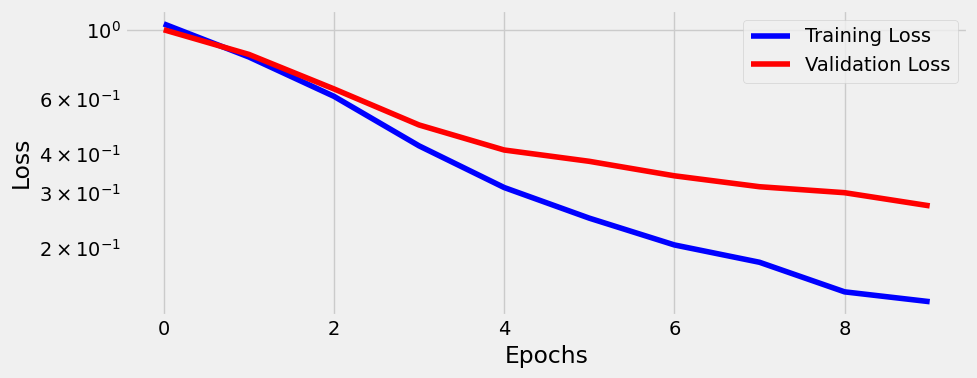

In [42]:
fig = arch_cnn2.plot_losses()

### Accuracy

In [43]:
Architecture.loader_apply(val_loader,
                          arch_cnn2.correct)

tensor([[ 89, 124],
        [118, 124],
        [117, 124]])

In [44]:
Architecture.loader_apply(val_loader,
                          arch_cnn2.correct).sum(axis=0)

tensor([324, 372])

In [45]:
(lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader,
                                                                arch_cnn2.correct).sum(axis=0))

0.8709677419354839

### Regularizing Effect

In [46]:
torch.manual_seed(13)
# Model Configuration
model_cnn2_nodrop = CNN2(n_feature=5, p=0.0)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_cnn2_nodrop = optim.Adam(model_cnn2_nodrop.parameters(), lr=3e-4)
# Model Training
arch_cnn2_nodrop = Architecture(model_cnn2_nodrop, multi_loss_fn, optimizer_cnn2_nodrop)
arch_cnn2_nodrop.set_loaders(train_loader, val_loader)
arch_cnn2_nodrop.train(10)

In [47]:
def figure11(losses, val_losses, losses_nodrop, val_losses_nodrop):
    fig, axs = plt.subplots(1, 1, figsize=(10, 5))
    axs.plot(losses, 'b', label='Training Losses - Dropout')
    axs.plot(val_losses, 'r', label='Validation Losses - Dropout')
    axs.plot(losses_nodrop, 'b--', label='Training Losses - No Dropout')
    axs.plot(val_losses_nodrop, 'r--', label='Validation Losses - No Dropout')
    plt.yscale('log')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Regularizing Effect')
    fig.legend(loc='lower left')
    fig.tight_layout()
    return fig

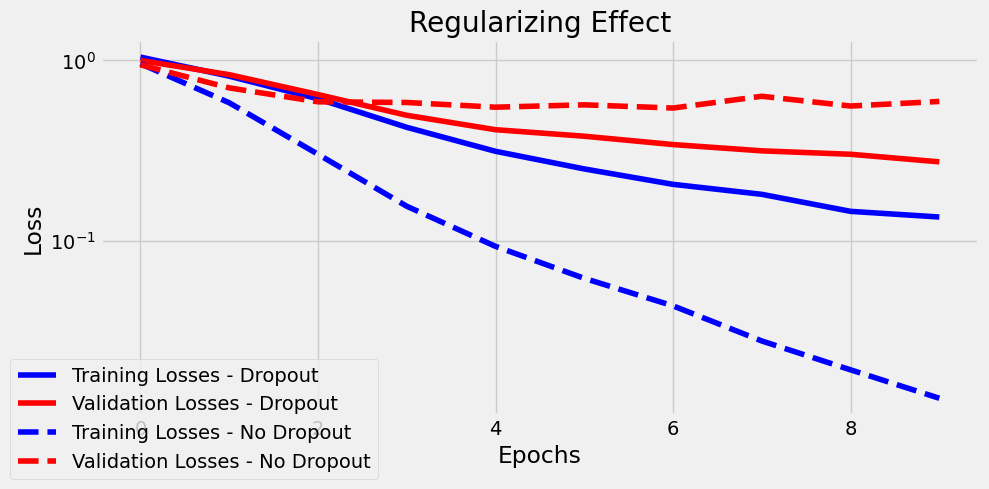

In [48]:
fig = figure11(arch_cnn2.losses, arch_cnn2.val_losses, arch_cnn2_nodrop.losses, arch_cnn2_nodrop.val_losses)

In [49]:
print(
    Architecture.loader_apply(train_loader, arch_cnn2_nodrop.correct).sum(axis=0),
    Architecture.loader_apply(val_loader, arch_cnn2_nodrop.correct).sum(axis=0)
)

tensor([2520, 2520]) tensor([292, 372])


In [50]:
print(
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(train_loader, arch_cnn2_nodrop.correct).sum(axis=0)),
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader, arch_cnn2_nodrop.correct).sum(axis=0))
)

1.0 0.7849462365591398


In [51]:
print(
    Architecture.loader_apply(train_loader, arch_cnn2.correct).sum(axis=0),
    Architecture.loader_apply(val_loader, arch_cnn2.correct).sum(axis=0)
)

tensor([2503, 2520]) tensor([324, 372])


In [52]:
print(
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(train_loader, arch_cnn2.correct).sum(axis=0)),
    (lambda x: x[0].item() / x[1].item())(Architecture.loader_apply(val_loader, arch_cnn2.correct).sum(axis=0))
)

0.9932539682539683 0.8709677419354839


### Visualizing Filters

In [53]:
model_cnn2.conv1.weight.shape

torch.Size([5, 3, 3, 3])

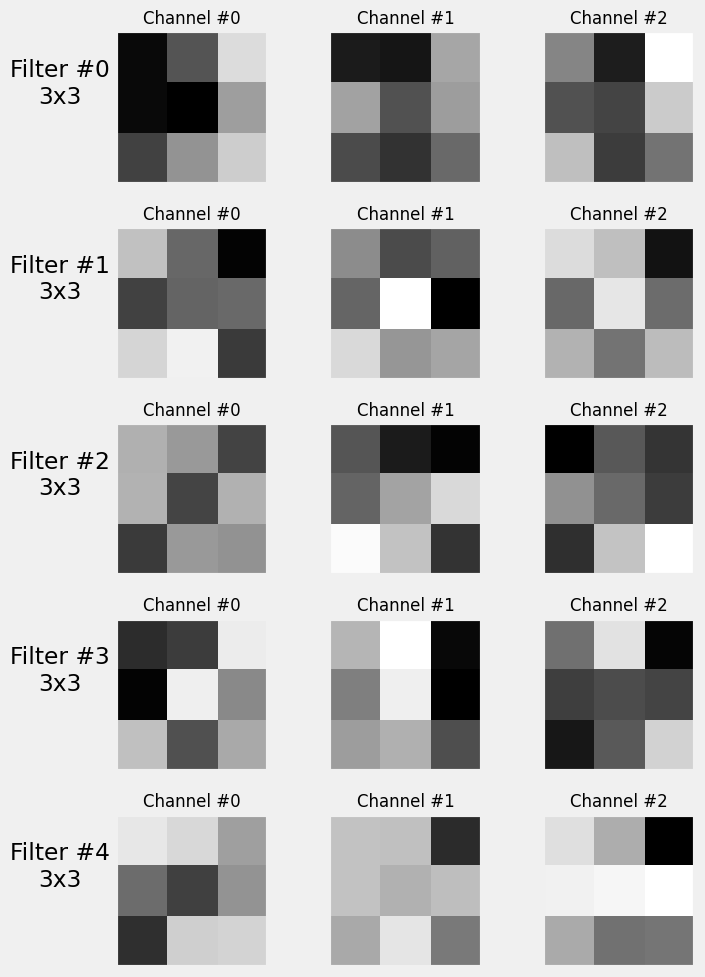

In [54]:
fig = arch_cnn2.visualize_filters('conv1')

In [55]:
model_cnn2.conv2.weight.shape

torch.Size([5, 5, 3, 3])

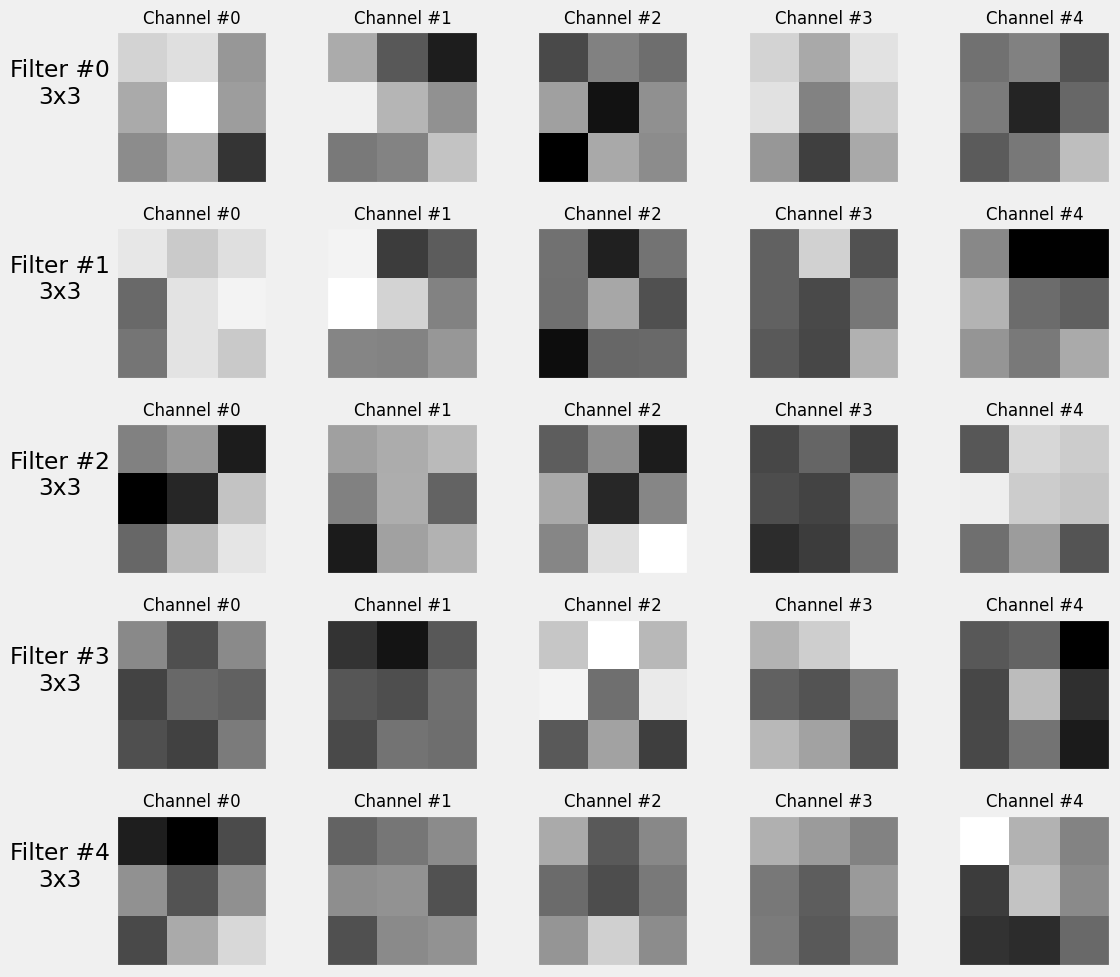

In [56]:
fig = arch_cnn2.visualize_filters('conv2')

# Learning Rates

## Finding LR

First, we need to define the boundaries for the test (``start_lr`` and ``end_lr``) and the number of iterations (``num_iter``) to move from one to the other. On top of that, we can choose to change how to make the increments: **linearly** or **exponentially**. Let’s build a higher-order function that takes all those arguments and returns another
function, one that returns the multiplying factor given the current iteration number:

In [85]:
def make_lr_fn(start_lr, end_lr, num_iter, step_mode='exp'):
    if step_mode == 'linear':
        factor = (end_lr / start_lr - 1) / num_iter
        def lr_fn(iteration):
            return 1 + iteration * factor
    else:
        factor = (np.log(end_lr) - np.log(start_lr)) / num_iter
        def lr_fn(iteration):
            return np.exp(factor)**iteration
    return lr_fn

In [103]:
start_lr = 0.01
end_lr = 0.1
num_iter = 10
lr_fn = make_lr_fn(start_lr, end_lr,
                   num_iter, step_mode='exp')

In [101]:
lr_fn(np.arange(num_iter + 1))

array([ 1.        ,  1.25892541,  1.58489319,  1.99526231,  2.51188643,
        3.16227766,  3.98107171,  5.01187234,  6.30957344,  7.94328235,
       10.        ])

In [102]:
start_lr * lr_fn(np.arange(num_iter + 1))

array([0.01      , 0.01258925, 0.01584893, 0.01995262, 0.02511886,
       0.03162278, 0.03981072, 0.05011872, 0.06309573, 0.07943282,
       0.1       ])

In [97]:
start_lr = 0.01
end_lr = 0.1
num_iter = 10
lr_fn = make_lr_fn(start_lr, end_lr, num_iter, step_mode='linear')

In [98]:
lr_fn(np.arange(num_iter + 1))

array([ 1. ,  1.9,  2.8,  3.7,  4.6,  5.5,  6.4,  7.3,  8.2,  9.1, 10. ])

In [99]:
start_lr * lr_fn(np.arange(num_iter + 1))

array([0.01 , 0.019, 0.028, 0.037, 0.046, 0.055, 0.064, 0.073, 0.082,
       0.091, 0.1  ])

In [116]:
dummy_model = CNN2(n_feature=5, p=0.3)
dummy_optimizer = optim.Adam(dummy_model.parameters(), lr=start_lr)
dummy_scheduler = LambdaLR(dummy_optimizer, lr_lambda=lr_fn)

In [117]:
dummy_optimizer.step()
dummy_scheduler.step()

In [118]:
dummy_scheduler.get_last_lr()[0]

0.012589254117941673

In [119]:
torch.manual_seed(13)
new_model = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)

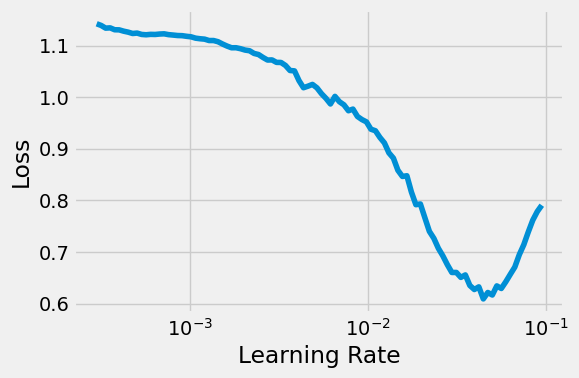

In [120]:
arch_new = Architecture(new_model, multi_loss_fn, new_optimizer)
tracking, fig = arch_new.lr_range_test(train_loader, end_lr=1e-1, num_iter=100)

In [121]:
min_loss = min(tracking['loss'])
min_loss_index = tracking['loss'].index(min_loss)
corresponding_lr = tracking['lr'][min_loss_index]

min_loss, corresponding_lr

(0.6091022460474141, 0.04434013138652989)

In [122]:
new_optimizer = optim.Adam(new_model.parameters(), lr=0.005)
arch_new.set_optimizer(new_optimizer)
arch_new.set_loaders(train_loader, val_loader)
arch_new.train(10)

In [ ]:
# This plot wasn't included in the book
fig = arch_new.plot_losses()

## LRFinder

In [123]:
!pip install --quiet torch-lr-finder

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 18.1 MB/s eta 0:00:00


In [124]:
from torch_lr_finder import LRFinder

/usr/local/lib/python3.10/dist-packages/torch_lr_finder/lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Instead of calling a function directly, we need to create an instance of ``LRFinder`` first, using the typical model configuration objects (model,
optimizer, loss function, and the device). Then, we can take the ``range_test()``
method for a spin, providing familiar arguments to it: a data loader, the upper
range for the learning rate, and the number of iterations. The ``reset()`` method restores the original states of both model and optimizer.

  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 9.02E-03


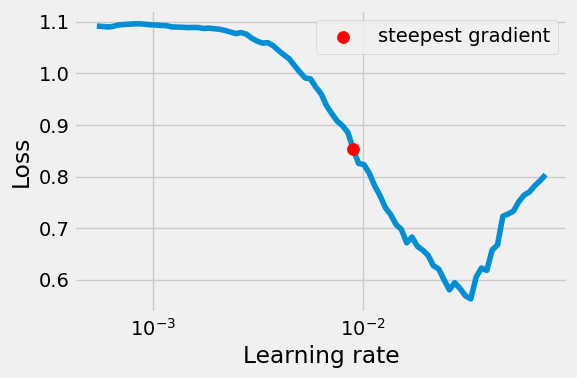

In [125]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

torch.manual_seed(11)
new_model = CNN2(n_feature=5, p=0.3)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
new_optimizer = optim.Adam(new_model.parameters(), lr=3e-4)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

lr_finder = LRFinder(new_model, new_optimizer, multi_loss_fn, device=device)
lr_finder.range_test(train_loader, end_lr=1e-1, num_iter=100)
lr_finder.plot(ax=ax, log_lr=True)

fig.tight_layout()
lr_finder.reset()